In [974]:
# convert from custom dark mode back to normal

!jt -r

Reset css and font defaults in:
/Users/cmeaton/.jupyter/custom &
/Users/cmeaton/Library/Jupyter/nbextensions


# Predicting beef cattle production

### Why is this important?
Meat production, and particularily beef cattle, is a very interconnected, complex, and expensive process that is crucial to local and global economies. The complexities of its production stem from the fact that before one can raise cattle, one must raise its food. While cattle are natural ruminants, improvements in agricultural processes starting in the mid 20th century have trended towards the production of corn and soy for cattle feed. 

This makes raising and harvesting cattle reliant upon multiple sectors of the global agricultural industry. Despite its complexity and expense, demand for beef cattle has been rising world wide. As a result, I am posing the following questions:

**1.) Can total production of beef per country in a given year can be predicted?**

**2.) If so, what features most strongly predict production? **

Digging into these questions with regression analysis may improve our understanding and optimization of our global food production sytem.

### Alot of libraries and tools were used

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

### The first data I am importing is from the Food and Agriculture Organization, which has been keep records on a variety of agricultural metrics for every country since 1961.

Each file has **11137 rows and 3 columns**. Here I am importing the following data:
    - Total head of cattle (living)
    - Total area in soy production (hectares)
    - Total yield of soy (hectagrams per hectares)
    - Total area in corn production (hectares)
    - Total yield of corn (hectagrams per hectares)
    - Mean weight of harvested cattle (hectagrams per animal)
    - Total number of harvested cattle
    - Total human population in rural areas per country
    - Total human population in urban areas per country
    

In [200]:
cd datafiles/

[Errno 2] No such file or directory: 'datafiles/'
/Users/cmeaton/Downloads/predicting_cattle_yield-master/datafiles


In [3]:
df_head = pd.read_csv('head.csv')
df_soy_area = pd.read_csv('soy_area.csv')
df_soy_yield = pd.read_csv('soy_yield.csv')
df_cattle_weight = pd.read_csv('cattle_yield.csv')
df_cattle_harvestnum = pd.read_csv('cattle_weight.csv')
df_corn_area = pd.read_csv('corn_area.csv')
df_corn_yield = pd.read_csv('corn_yield.csv')
df_rural = pd.read_csv('rural_pop.csv')
df_urban = pd.read_csv('urban_pop.csv')

### Merging.

To group all of this data into one dataframe, I need to create a shared column to merge on. This column concatinates Country and Year, which every file has.

In [4]:
df_head['CountryYear'] = df_head['Area'].apply(str) + ' ' + df_head['Year'].apply(str)
df_soy_area['CountryYear'] = df_soy_area['Area'].apply(str) + ' ' + df_soy_area['Year'].apply(str)
df_soy_yield['CountryYear'] = df_soy_yield['Area'].apply(str) + ' ' + df_soy_yield['Year'].apply(str)
df_cattle_harvestnum['CountryYear'] = df_cattle_harvestnum['Area'].apply(str) + ' ' + df_cattle_harvestnum['Year'].apply(str)
df_cattle_weight['CountryYear'] = df_cattle_weight['Area'].apply(str) + ' ' + df_cattle_weight['Year'].apply(str)
df_corn_area['CountryYear'] = df_corn_area['Area'].apply(str) + ' ' + df_corn_area['Year'].apply(str)
df_corn_yield['CountryYear'] = df_corn_yield['Area'].apply(str) + ' ' + df_corn_yield['Year'].apply(str)
df_rural['CountryYear'] = df_rural['Area'].apply(str) + ' ' + df_rural['Year'].apply(str)
df_urban['CountryYear'] = df_urban['Area'].apply(str) + ' ' + df_urban['Year'].apply(str)

Renaming columns

In [5]:
df_head = df_head.rename(columns={'Value':'Cattle_head'})
df_soy_area = df_soy_area.rename(columns={'Value':'Soy_area_ha'})
df_soy_yield = df_soy_yield.rename(columns={'Value':'soy_hg/ha'})
df_cattle_harvestnum = df_cattle_harvestnum.rename(columns={'Value':'harvest_num'})
df_cattle_weight = df_cattle_weight.rename(columns={'Value':'hg/animal'})
df_corn_area = df_corn_area.rename(columns={'Value':'corn_area_ha'})
df_corn_yield = df_corn_yield.rename(columns={'Value':'corn_hg/ha'})
df_rural = df_rural.rename(columns={'Value':'rural_pop_10^3'})
df_urban = df_urban.rename(columns={'Value':'urban_pop_10^3'})

Removing unneeded columns


In [6]:
df_head = df_head[['CountryYear','Area', 'Year', 'Cattle_head']]
df_soy_area = df_soy_area[['CountryYear','Soy_area_ha']]
df_soy_yield = df_soy_yield[['CountryYear','soy_hg/ha']]
df_cattle_harvestnum = df_cattle_harvestnum[['CountryYear','harvest_num']]
df_cattle_weight = df_cattle_weight[['CountryYear','hg/animal']]
df_corn_area = df_corn_area[['CountryYear','corn_area_ha']]
df_corn_yield = df_corn_yield[['CountryYear','corn_hg/ha']]
df_rural = df_rural[['CountryYear','rural_pop_10^3']]
df_urban = df_urban[['CountryYear', 'urban_pop_10^3']]


Merge dataframes together into the master. As a result of the merging, many rows that did not contain complete data were dropped. The master dataframe is now 2953 rows by 11 columns.

In [7]:
df_master = pd.merge(df_head, df_soy_area, on='CountryYear')
df_master = pd.merge(df_master, df_soy_yield, on='CountryYear')
df_master = pd.merge(df_master, df_cattle_harvestnum, on='CountryYear')
df_master = pd.merge(df_master, df_cattle_weight, on='CountryYear')
df_master = pd.merge(df_master, df_corn_area, on='CountryYear')
df_master = pd.merge(df_master, df_corn_yield, on='CountryYear')
df_master = pd.merge(df_master, df_rural, on='CountryYear')
df_master = pd.merge(df_master, df_urban, on='CountryYear')

### Before going further, I wanted to take a first glance at the correlations in my dataframe.

Many of the column within this data frame correlate strongly with one another. This is a good start in building a model with strong predictive power.

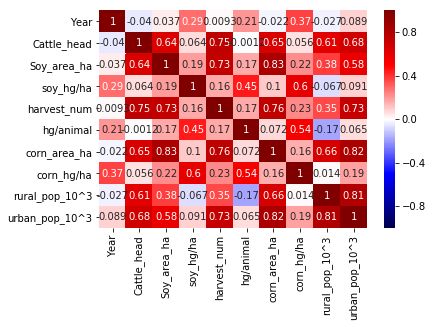

In [76]:
sns.heatmap(df_master.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

## Web Scraping

### Using selenium to access climate data.

Data source: http://sdwebx.worldbank.org/climateportal/index.cfm?page=downscaled_data_download&menu=historical

This data source contains yearly total precipitation for every country between 1901 and 2015, which is even more comprehensive than what I need. Regardless, I used selenium to scrape the data.

The wesbite was structured with multiple drop down menus with a variety of categories. Once all the desired categories were selected, a few buttons had to be clicked and then a .xls file on the data could be downloaded to your machine. I built a selenium bot that iterated through every drop down menu selection for each country and navigated the necassary pages to download each country-specific .xls file.

In [650]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import time
import os


#open my webpage
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)
driver.get("http://sdwebx.worldbank.org/climateportal/index.cfm?page=downscaled_data_download&menu=historical")


# get list of all country options
drop_list = []
country_list = []
select_country = Select(driver.find_element_by_id('country'))
for option in select_country.options:
    drop_list.append(option.text)

# set country list length -- list stops at 100, so setting the index for the drop_list
# every 100 pages it scrapes
country_list = drop_list[201:]

# looping through all pages to get precep data from all countries
for country in country_list:
    
    # click variable button
    select_var = Select(driver.find_element_by_id('variablesHist'))
    select_var.select_by_visible_text('Rainfall')

    # click country button
    select_country = Select(driver.find_element_by_id('country'))
    select_country.select_by_visible_text(country)

    #click time period
    select_time = Select(driver.find_element_by_id('histTimeSeries'))
    select_time.select_by_visible_text('1901-2015')

    # click submit button
    submit_button = driver.find_elements_by_xpath('//*[@id="btnDiv"]/input')[0]
    submit_button.click()

    # click download button
    download_button = driver.find_elements_by_xpath('//*[@id="file1"]')[0]
    download_button.click()
    time.sleep(8)

    # click download button
    cancel_button = driver.find_elements_by_xpath('//*[@id="home"]/div[5]/div[11]/div/button/span')[0]
    cancel_button.click()





## Cleaning data from my web scraping.

My selenium bot provided me with a seperate file for every country. In addition, data was recorded at monthly intervals, not yearly, so I had to clean the data to fit my needs. After dropping unneeded columns, I merged all of my cleaned files into one master precipitation data frame.

In [8]:
import glob

# setting directory paths and looping in all files from directories
path_1 = "/Users/cmeaton/Documents/code/ds/METIS/sea19_ds7_workingdir/Project_Luther/predicting_cattle_yield/precipitation data_1/*.xls"
path_2 = "/Users/cmeaton/Documents/code/ds/METIS/sea19_ds7_workingdir/Project_Luther/predicting_cattle_yield/precipitation data_2/*.xls"
path_3 = "/Users/cmeaton/Documents/code/ds/METIS/sea19_ds7_workingdir/Project_Luther/predicting_cattle_yield/precipitation data_3/*.xls"

df_precip_1 = pd.concat([pd.read_excel(f, encoding='latin1') for f in glob.glob(path_1)])
df_precip_2 = pd.concat([pd.read_excel(f, encoding='latin1') for f in glob.glob(path_2)])
df_precip_3 = pd.concat([pd.read_excel(f, encoding='latin1') for f in glob.glob(path_3)])

df_total_precip = pd.concat([df_precip_1, df_precip_2, df_precip_3])

# computing annual sum precipitation
year_sum = df_total_precip.groupby(np.arange(len(df_total_precip))//12).sum()
year_sum = year_sum.reset_index()

# filtering non-summed data by every 12th row
every_12 = df_total_precip.iloc[::12, :]
every_12 = every_12.reset_index()

# merging annual sum data onto every 12th data and renaming columns
df_total_precip_merged = pd.merge(year_sum,every_12, on = 'index')
df_total_precip_merged = df_total_precip_merged.drop(columns=['index', ' Month',' ISO3_x', ' ISO2_x', 'pr_y', ' ISO3_y', ' ISO2_y'])
df_total_precip_merged =df_total_precip_merged.rename(columns={'pr_x': 'annual_sum_precipitation'})

## More cleaning.

Additional cleaning had to take place as the country labels in the precipitation data was in a 3 letter code. My  master data frame contained country by full name, not code, so in order to merge the data frames together, I needed to convert codes to full country name. I did this with the aid of the pycountry library.

In [9]:
import pycountry

def get_country_code(name):
    '''Using pycountry to get list of country names from code names in df'''
    for co in list(pycountry.countries):
        if name in co.alpha_3:
            return co.name
    return None
names = df_total_precip_merged[' Country']

codes_ = []
names_ = []
for name in names:
    codes_.append(name)
    names_.append(get_country_code(name))

# adding codes and country names to df
df_total_precip_merged['x']= codes_
df_total_precip_merged['y']= names_

# confirm code columns are equal
df_total_precip_merged[' Country'].equals(df_total_precip_merged['x'])

# create new column combining country and year
df_total_precip_merged['\tYear'] = df_total_precip_merged['\tYear'].apply(str)
df_total_precip_merged['CountryYear'] = df_total_precip_merged['y'] + ' ' + df_total_precip_merged['\tYear']

# merge annual sum precipitation onto master df and drop unneeded columns
df_master = pd.merge(df_master, df_total_precip_merged, on='CountryYear')


## More data.

Until now, my master data frame did not have a very useful, presice metric for beef cattle production that I could use. I was really looking for the total weight of produced beef every year, which is a far more useful interpretable value to predict. Fortunately, I found some additional data had production totals for beef cattle per country per year. As an added bonus, the data also had beef cattle supply per capita (hooray more features!).

In [10]:
# loading in additional data on meat supply/person and meat production/country in tonnes

df_meat_supply_per_person = pd.read_csv('meat-supply-per-person.csv')
df_meat_prod_tonnes = pd.read_csv('meat-production-tonnes.csv')

df_meat_supply_per_person['CountryYear'] = df_meat_supply_per_person['Entity'] + ' ' +  df_meat_supply_per_person['Year'].apply(str)
df_meat_prod_tonnes['CountryYear'] = df_meat_prod_tonnes['Entity'] + ' ' +  df_meat_prod_tonnes['Year'].apply(str)

df_master = pd.merge(df_master, df_meat_supply_per_person, on='CountryYear')
df_master = pd.merge(df_master, df_meat_prod_tonnes, on='CountryYear')
df_master = df_master.rename(index=str, columns={"Food Balance Sheets: Meat - Food supply quantity (kg/capita/yr) (FAO (2017)) (kg)": "supply_g/capita",
                                                 "Livestock Primary: Meat, Total - Production - tonnes (FAO (2017)) (tonnes)": "production_tons"})
# df_master = df_master.rename(columns={'Value':'GDP'})

### One more data set.

The purpose of this project is to make a predictive model using a linear regression. This means that any categorical data I have needs to be either dropped or converted into a numerical feature. I had the name of each country in my data, which I did not want to lose in my model by dropping it. To effectively incorporate country into my model, I found a data set that included the total GDP per country per year. I was able to merge this data into my master data frame and treat as a proxy for country.

In [11]:
df_gdp = pd.read_csv('gdp.csv')
df_gdp['CountryYear'] = df_gdp['Country Name'] + " " + df_gdp['Year'].apply(str)
df_master = pd.merge(df_master, df_gdp, on='CountryYear')

## Normalization.

My data was on very different scales. For example, an average number of cattle in a country on a given year would be 6000000 and cattle weight was listed in hectagrams per animal, which was around 800-1200. These numbers would be interprated very differently by my model, so I did some multiplication and division to get all of my data on the same order of magnitude.



In [12]:
df_master['g/animal'] = df_master['hg/animal'] * 100
df_master['rural_pop_e+01'] = df_master['rural_pop_10^3'] * 100
df_master['urban_pop_e+01'] = df_master['urban_pop_10^3'] * 100
df_master['annual_sum_precipitation_mm_e-02'] = df_master['annual_sum_precipitation'] * 100
#df_master['shifted_annual_sum_precipitation(mm_e-02)'] = df_master['shifted_annual_sum_precipitation'] * 100
df_master['GDP/100000'] = df_master['Value'] / 100000
df_master['supply_g/capita'] = df_master['supply_g/capita'] * 1000

In [113]:
df_master = df_master.drop(columns=['Food Balance Sheets: Meat - Food supply quantity (kg/capita/yr) (FAO (2017)) (kg)'])

In [13]:
# Getting rid of some now uneeded columns.

df_master = df_master.drop(columns=['rural_pop_10^3', 'urban_pop_10^3', 'annual_sum_precipitation',
       '\tYear', ' Country', 'x', 'y', 'Entity_x', 'Code_x', 'Year_y','Entity_y', 'Code_y', 'Year_x',
                       'Country Name', 'Country Code', 'Year_y', 'Value','hg/animal'])

### Now that my master data frame is complete, I want to tinker with it.
Before doing this, I need to make a copy to play with, so that I can preserve the original data frame if needed. 

In [217]:
df_model = df_master.copy()

In [15]:
# rename all features
df_model = df_model.rename(columns={'Cattle_head':'cattle_head',
                          'Soy_area_ha':'soy_area_ha', 
                          'soy_hg/ha':'soy_area_hg/ha', 
                          'harvest_num':'harvest_number',
                          'g/animal':'mean_g/animal',
                          'corn_area_ha':'corn_area_ha',
                          'corn_hg/ha':'corn_hg/ha',
                          'rural_pop_e+01':'rural_pop_e+01',
                          'urban_pop_e+01':'urban_pop_e+01',
                          'annual_sum_precipitation(mm_e-02)':'total_precipitation_mm_e-02', 
                          'Supply (g/capita)':'supply_g/capita',
                          'GDP/100000':'GDP_e+05',
                          'Production (tonnes)':'production_tons'})


### Outliers

A few ilogical outliers were found, so they were removed.

In [16]:
#remove outliers
df_model[df_model['mean_g/animal'] > 600000] = 0
df_model[df_model['supply_g/capita'] > 1400000] = 0
df_model[df_model['mean_g/animal'] == 0] = 0
df_model[df_model['production_tons'] > 8000000] = 0


### Distribution of my y.

Before diving into modeling, I want to see how my y variable is distributed.

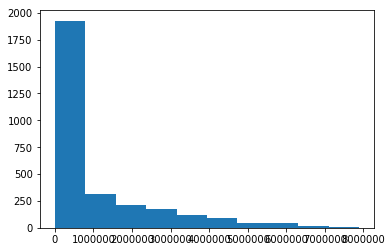

In [237]:
plt.hist(df_model['production_tons']);

Looks like its VERY heavily right skewed, which I suppose makes sense. Many countries may not produce beef for a variety of cultural, economic, or geographic reasons. However, I will leave non-producing countries in my model because lack of production may be a yearly factor, not an indefinite pattern and I don't my model to miss this.

Because of this skewness, I will log transform my model, which should make it a bit more normally distributed for better modelling and interpretability. This helps a bit, minus the spike over zero.

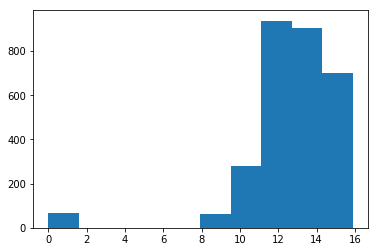

In [236]:
df_model['production_tons_log'] = np.log1p(df_model['production_tons'])

plt.hist(df_model['production_tons_log']);

## Modeling.

First steps were creating my X and y. X contains all of my features and y is my predicted value. As you can see, I ended up creating and dropping many features to reduce model complexity. I dropped these features by observing how my Lasso regression automatically pushed their coefficents down to zero, indicating their lack of contribution to the model. I confirmed this by rerunning my model without these features, one by one, and observed no real change in the efficacy of the model.

Using the train_test_split function from sklearn, seperated 20% of my data out to be reserved for the final test. The other 80% of the data became my training set to work with.
    


In [248]:
X = df_model.drop(['production_tons_log',
                   'production_tons',
                   'Brazil','rural_pop_e+01',
                   'mean_g/animal',
                   'annual_sum_precipitation_mm_e-02',
                   'India','CountryYear',
                   'Area',
                   'soy_area_ha',
                   'corn_area_ha', 
                   'GDP_e+05', 
                   'cattle_head_log',
                  ], axis=1)

y = df_model['production_tons_log']

#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

## Cross validation: Part 1
### LassoCV and RidgeCV

To properly build an accurate model, cross validation is a necassary technique. Because I already split my testing and training data, I can easily run cross validation with 5 folds on my training data. I will do this with Lasso and Ridge regression and compare results.

Because I already manually transformed my data to be on the same order of magnitude, applying a standard scalar was not fully necassary. I did this anyway to compare, and it ended up reducing the overall predictive power so I did not apply this to my final model.

As a result, my final model had the following features: *cattle_head, soy_area_ha, soy_area_hg/ha, harvest_number,corn_area_ha, corn_hg/ha, urban_pop_e+01, GDP_e+05, supply_g/capita, 'China, and Brazil*.


In [241]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

# create alpha
alphavec = 100**np.linspace(-2,2,200)

# create models
lasso_model = LassoCV(alphas = alphavec, cv=5, tol=0.1)
lasso_model.fit(X_train, y_train)
ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)


# Scaling data made r2 value drop by .07
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(X_train)
# scaled_data_test = scaler.fit_transform(X_test)

## Scale the Predictors on both the train and test set
# X_tr = std.transform(X_train.values)
# X_te = std.transform(X_test.values)

LassoCV(alphas=array([1.00000e-04, 1.09699e-04, ..., 9.11589e+03, 1.00000e+04]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.1,
    verbose=False)

In [192]:
# Training each model on training data

yhat_val_lasso = lasso_model.predict(X_train)
yhat_val_ridge = ridge_model.predict(X_train)

### Regularization.

Below are the coefficents for each feature set by the Lasso and Ridge regression. The features I dropped earlier had coefficents at 0 for Lasso and Ridge regression.

In [239]:
list(zip(X_train.columns, lasso_model.coef_))

[('cattle_head', 9.556734069197032e-10),
 ('soy_area_hg/ha', -1.9682598163835327e-05),
 ('harvest_number', 3.688018807232692e-09),
 ('corn_hg/ha', -1.1206372649319327e-05),
 ('supply_g/capita', 1.2817508530288328e-05),
 ('urban_pop_e+01', 1.2769171119348525e-08),
 ('China', 1.046044465216307),
 ('soy_area_ha_log', 0.021338339431627964),
 ('corn_area_ha_log', 0.20493389332876238),
 ('GDP_e+05_log', 0.5675005025486575)]

In [240]:
list(zip(X_train.columns, ridge_model.coef_))

[('cattle_head', 1.7079804431763852e-09),
 ('soy_area_hg/ha', -1.8601008872546798e-05),
 ('harvest_number', 1.968125026160673e-08),
 ('corn_hg/ha', -1.063350039662247e-05),
 ('supply_g/capita', 1.1071253573468656e-05),
 ('urban_pop_e+01', -5.651153785579404e-09),
 ('China', 1.4125141044135365),
 ('soy_area_ha_log', 0.019474377623027853),
 ('corn_area_ha_log', 0.19312484581651454),
 ('GDP_e+05_log', 0.5803768427968997)]

In [242]:
print('r2 value for lasso is ', r2_score(y_train, yhat_val_lasso))
print('r2 value for ridge is ', r2_score(y_train, yhat_val_ridge))

print('alpha value for lasso is ', lasso_model.alpha_)
print('alpha value for ridge is ', ridge_model.alpha_)

r2 value for lasso is  0.8973968591167503
r2 value for ridge is  0.898570625615788
alpha value for lasso is  0.0001
alpha value for ridge is  0.0001


In [194]:
# finding residuals from first model training

residual_lasso = y_train - yhat_val_lasso
residual_ridge = y_train - yhat_val_ridge

### Both models produced very strong r2 values, but this is without any real feature engineering. To aid in this, I build a function to plot my residuals for each feature.

In [196]:
def scatter(feature):
    '''
    The input for this function is "feature", which is one of the features in the model. 
    Input the feature in this format "df_model[column name]" and it will plot a scatter plot
    against y, the number of harvested cattle as well as return r.
    
    List of features to choose from: ['cattle_head', 'soy_area_ha', 'soy_area_hg/ha', 'harvest_number',
       'mean_g/animal', 'corn_area_ha', 'corn_hg/ha', 'rural_pop_e+01',
       'urban_pop_e+01', 'total_precipitation_mm_e-02',
       'shifted_annual_sum_precipitation(mm_e-02)', 'production_tons',
       'supply_g/capita', 'GDP_e+05']
    '''
    
    plt.scatter(feature, residual_lasso, alpha=.7)
    #plt.xlabel(x_column.text())
    plt.ylabel('residual')
    plt.title('Residual Plot')
    plt.show();
    print('The correlation coefficient is: ', residual_lasso.corr(feature))


### Based on studying my residual plots, I applied the following transformations to flatten the residual distribution closer to 0.


In [243]:
# log transform cattle_head
    # this bumped up r2 value from .94 to .95
df_model['cattle_head_log'] = np.log(df_model['cattle_head'])
# log transform soy_area_ha
    # no effect on r2
df_model['soy_area_ha_log'] = np.log(df_model['soy_area_ha'])
# # log transform corn_area_ha
#     # no effect on r2
df_model['corn_area_ha_log'] = np.log(df_model['corn_area_ha'])
# # log transform GDP_e+05
#     # no effect on r2
df_model['GDP_e+05_log'] = np.log(df_model['GDP_e+05'])





### Feature engineering continued.

I noticed that annual precipitation wasn't having too strong an effect in my model. This made me think, what if the average harvest time in a country comes before its rainy season? If this is this case, which is likely in many parts of the world, then the annual rainfall of the year may more strongly effect next years harvest. To assess this, I created a new feature which shifted rainfall up a year. However, this did not increase te predictive power of my model.

In [217]:
df_master['shifted_annual_sum_precipitation'] = df_master.annual_sum_precipitation.shift(1)

## Residual plots. 
Here are a few residual plots for some of my features (and sometimes its log transform) on the x and the residual on the y.

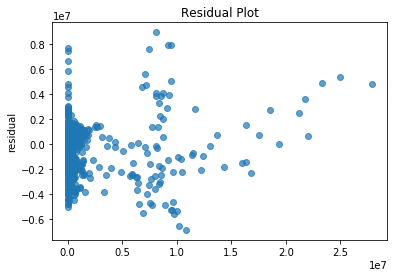

The correlation coefficient is:  -1.946076726509799e-07


In [136]:
scatter(X_train['soy_area_ha'])

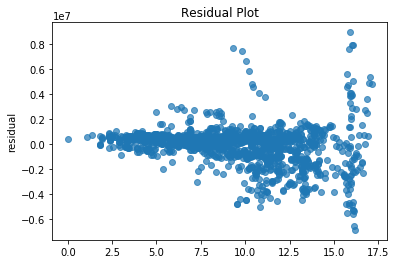

The correlation coefficient is:  -0.2260164525043981


In [137]:
scatter(X_train['soy_area_ha_log'])

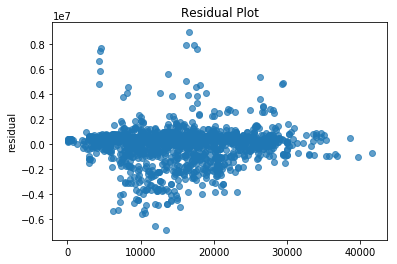

The correlation coefficient is:  -1.0284132573493838e-06


In [138]:
scatter(X_train['soy_area_hg/ha'])

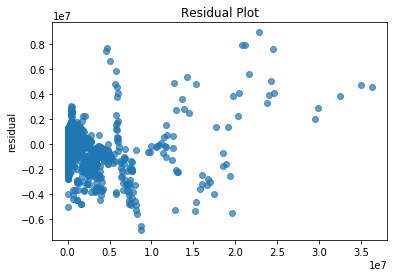

The correlation coefficient is:  -1.0077916352341693e-07


In [139]:
scatter(X_train['corn_area_ha'])

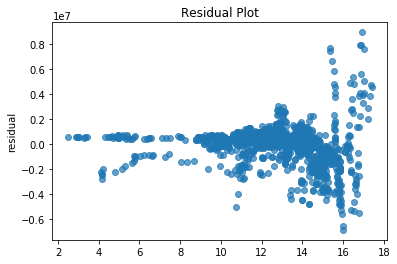

The correlation coefficient is:  -0.12220575253049337


In [140]:
scatter(X_train['corn_area_ha_log'])

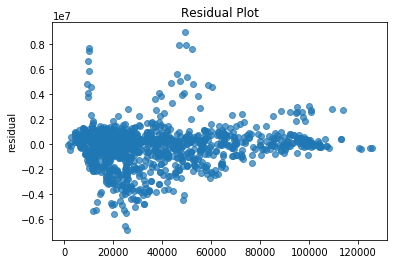

The correlation coefficient is:  1.254296615324869e-07


In [141]:
scatter(X_train['corn_hg/ha'])

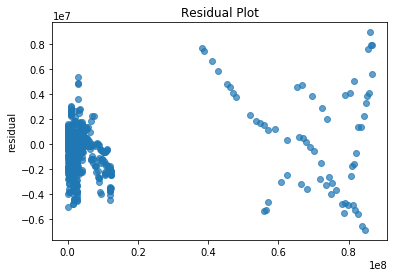

The correlation coefficient is:  -3.106669318566285e-07


In [145]:
scatter(X_train['rural_pop_e+01'])

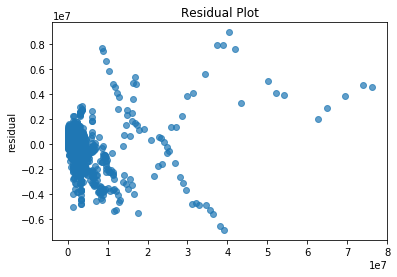

The correlation coefficient is:  7.327232809994135e-08


In [144]:
scatter(X_train['urban_pop_e+01'])

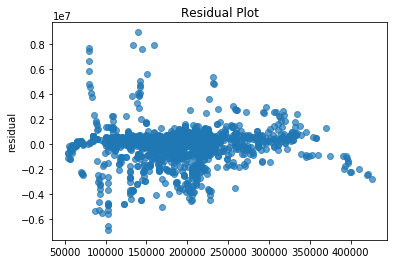

The correlation coefficient is:  -1.3165214534212877e-07


In [147]:
scatter(X_train['mean_g/animal'])


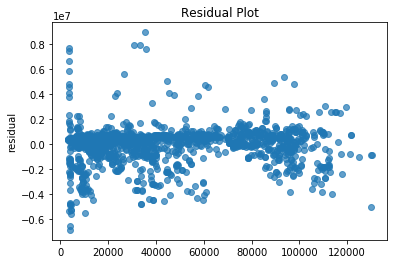

The correlation coefficient is:  -2.3245437856678455e-07


In [148]:
scatter(X_train['supply_g/capita'])

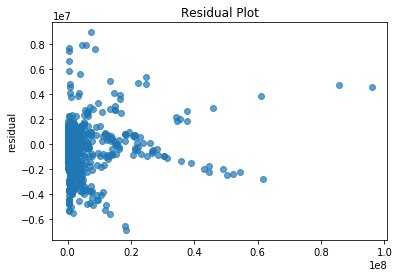

The correlation coefficient is:  -1.1565122343280324e-08


In [149]:
scatter(X_train['GDP_e+05'])

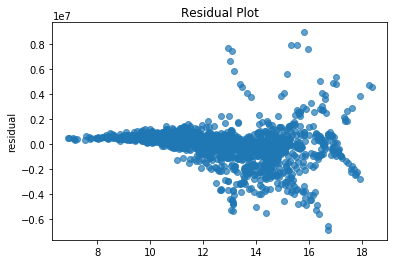

The correlation coefficient is:  -0.24659773662146497


In [150]:
scatter(X_train['GDP_e+05_log'])

## Interesting patterns.

Many of my residual plots exhibited variability that may indicate some categorical differences that I wasn't capturing. To dig in to this, I chose to tease apart the most dramatic feature, rural population.

Below is rural population(x) plotted against total production(y). It looks pretty funky.

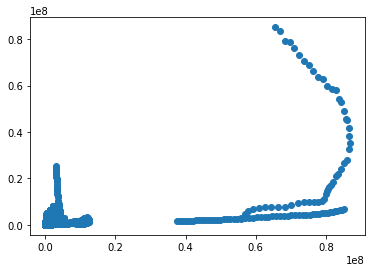

In [151]:
plt.scatter(df_model['rural_pop_e+01'], df_model['production_tons'])

### So I dug into the data and found that China, India, and Brazil created the unusual patterns.

In [152]:
# whats going on here?
    # China represents the off shoot that goes up in production
find = df_master[df_master['rural_pop_e+01']==df_master['rural_pop_e+01'].max()]
find


,CountryYear,Area,Year_x,Cattle_head,Soy_area_ha,soy_hg/ha,harvest_num,corn_area_ha,corn_hg/ha,production_tons,shifted_annual_sum_precipitation,g/animal,rural_pop_e+01,urban_pop_e+01,annual_sum_precipitation_mm_e-02,shifted_annual_sum_precipitation(mm_e-02),GDP/100000,Supply (g/capita)
625,China 1992,China,1992,82722948.0,7224840.0,14274,10169460.0,21119959.0,45347,35286861,966.7694,155200,86750100,35827466.9,98306.39,96676.94,4.269157e+06,28700.0


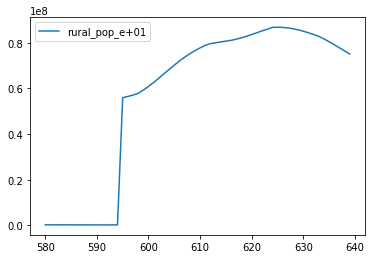

In [153]:
# China
df_master.iloc[580:640].plot(y='rural_pop_e+01')


In [255]:
# creating new dataframes to explore China, India and all countries that aren't those.
df_india = df_master[df_master['Area'] == 'India']
df_not_china_or_india = df_master[df_master['Area'] != 'India']
df_not_china_or_india = df_not_china_or_india[df_not_china_or_india['Area'] != 'China'] 

# # looking into patterns
# find2 = df_not_china[df_not_china['rural_pop_e+01']==df_not_china['rural_pop_e+01'].max()]
# find2

find3 = df_not_china_or_india[df_not_china_or_india['Cattle_head']==df_not_china_or_india['Cattle_head'].max()]
find3

# removing India from 
df_master_no_india = df_master[df_master['Area'] != 'India']


In [254]:
df_china = df_master[df_master['Area'] == 'China']
df_not_china = df_master[df_master['Area'] != 'China']

### To dig into this, I created functions to easily explore and plot residual plots for China, India, and for all countries combined not including China and India.

In [660]:
def scatter_China(feature):
    '''
    The input for this function is "feature", which is one of the features in the model. 
    Input the feature in this format "df_model[column name]" and it will plot a scatter plot
    against y, the number of harvested cattle as well as return r.
    '''
    plt.scatter(feature, df_china['Production (tonnes)'], alpha=.7)
    #plt.xlabel(x_column.text())
    plt.ylabel('residual')
    plt.title('Residual Plot')
    plt.show();
    print('The correlation coefficient is: ', df_china['Production (tonnes)'].corr(feature))

In [697]:
def scatter_India(feature):
    '''
    The input for this function is "feature", which is one of the features in the model. 
    Input the feature in this format "df_model[column name]" and it will plot a scatter plot
    against y, the number of harvested cattle as well as return r.
    '''
    plt.scatter(feature, df_india['Production (tonnes)'], alpha=.7)
    #plt.xlabel(x_column.text())
    plt.ylabel('production')
    #plt.title('Residual Plot')
    plt.show();
    print('The correlation coefficient is: ', df_india['Production (tonnes)'].corr(feature))

In [698]:
def scatter_NotChina_OrIndia(feature):
    '''
    The input for this function is "feature", which is one of the features in the model. 
    Input the feature in this format "df_model[column name]" and it will plot a scatter plot
    against y, the number of harvested cattle as well as return r.
    '''
    plt.scatter(feature, df_not_china_or_india['Production (tonnes)'], alpha=.7)
    #plt.xlabel(x_column.text())
    plt.ylabel('production')
    #plt.title('Residual Plot')
    plt.show();
    print('The correlation coefficient is: ', df_not_china_or_india['Production (tonnes)'].corr(feature))

This is an interesting plot showing the rural population in China growing and decreasing. Could this be atrributed to pre/post industrialization?

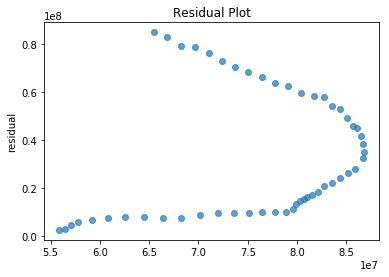

The correlation coefficient is:  0.22023190815097207


In [699]:
scatter_China(df_china['rural_pop_e+01'])

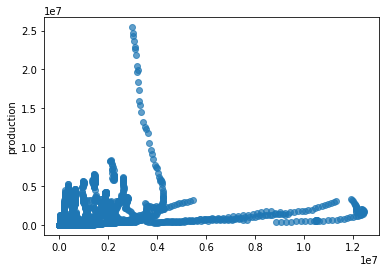

The correlation coefficient is:  0.18872481760050094


In [701]:
scatter_NotChina_OrIndia(df_not_china_or_india['rural_pop_e+01'])

## Interaction feature located.

China, India, and Brazil (who is shooting upward above) have an interaction with many features in my model. To handle this, I'm creating dummy variables for China, India, and Brazil due to their abnormalities to apply to the model. I also dropped India in the final model, which bumped up my r2 value by .015. As its a very large country with not much beef consumption, it was mucking up my model. 

There are many distinct offshoots in the visible here, indicating some categorical features that would benefit from teasing apart. Future work should definitely start here.

In [18]:
dummies = pd.get_dummies(df_master['Area'])
dummies[['China', 'India', 'Brazil']]

#merging dummies onto df_model
df_model = pd.concat([df_model, dummies[['China', 'India', 'Brazil']]], axis=1)

I couldn't resist a few more glances. Look what happens when India and China are removed from my data set. The offshoot you see is Brazil and in the conglomorate of points in the lower left quandrant show some really interesting patterns to dig into.

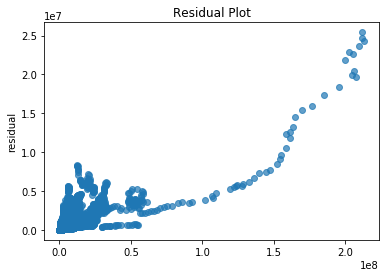

The correlation coefficient is:  0.7866863803977397


In [695]:
scatter_NotChina_OrIndia(df_not_china_or_india['Cattle_head'])

# Running the final test.

With my finalized model (LassoCV) made for the training data, its time to apply the model to the test set. 

The resultling r2 score was **0.887**! This model has very strong predictive power for beef cattle production.

In [183]:
test_set_pred = ridge_model.predict(X_test)

In [184]:
r2_score(y_test, test_set_pred)

0.8878529661019837

However, r2 isn't everything. The mean absolute error is an important statistic to incorporate as it can translate to interpretable results. 

The mean absolute error for my model was 13.08 (compared to 13.02 on my training data). This however is in log form. Calculating it back into its original scale, the MAE was is 479,269. This seems very high, but this is because of the large values in the y data. The range of data fell between 0 and 85,118,939, so this value seems appropriate.

In [137]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_test, test_set_pred)) 

mae(y_test, test_set_pred)
#mae(y_train, yhat_val_ridge)

13.083993168298528

### Visualizing the model.

Lets take a look at what this model looks like. It seems like there are some outliers in the test set, but that is neither here or there. The model shows strong predictive power, but improvements could definitely be made. Notice some straying patterns in the residual plot and some potential outliers in the distribution (QQ plot).

In [153]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y, color='black', alpha=.5)
    plt.plot(x, pred, color='red',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res, color='black', alpha=.5)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

/Users/cmeaton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


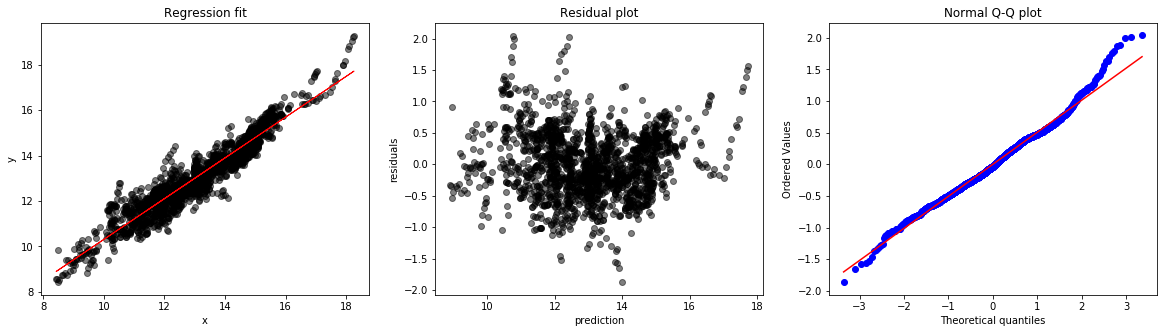

In [186]:
diagnostic_plot(y_train.reshape(-1,1), yhat_val_ridge) # we reshape x to turn it into a tall column

## Visualizations for presentation.

Below are some visuals created for presenting the model.

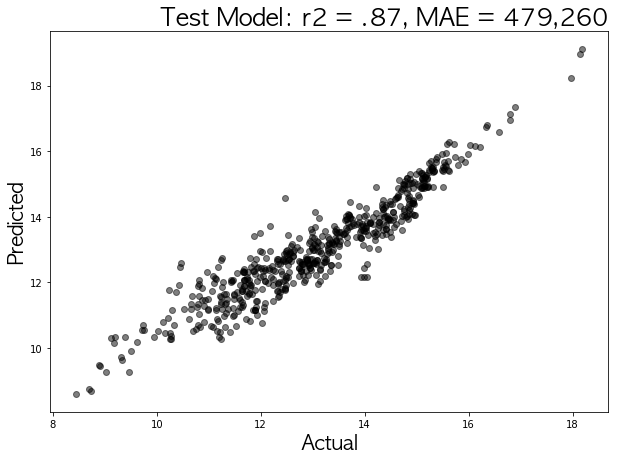

In [249]:
# test model

plt.figure(figsize=(10,7))
plt.scatter(y_test, test_set_pred, color='black', alpha=.5)
plt.title('Test Model: r2 = .87, MAE = 479,260', family='AppleGothic', loc='right', size=24)
plt.xlabel('Actual', family='AppleGothic', size=20)
plt.ylabel('Predicted', family='AppleGothic', size=20);


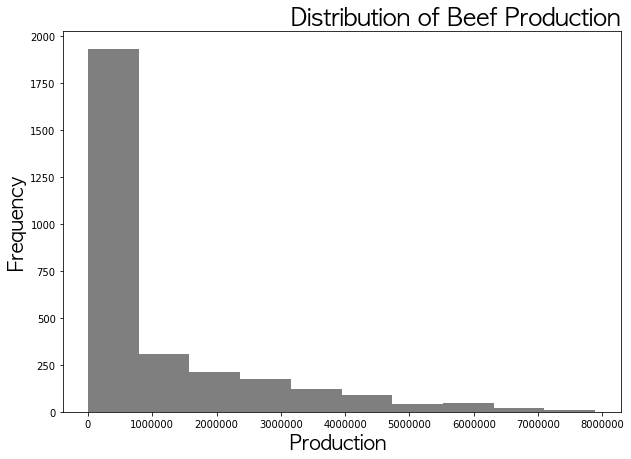

In [250]:
plt.figure(figsize=(10,7))
plt.hist(df_model['production_tons'],color='black', alpha=.5)
plt.title('Distribution of Beef Production', family='AppleGothic', loc='right', size=24)
plt.xlabel('Production ', family='AppleGothic', size=20)
plt.ylabel('Frequency', family='AppleGothic', size=20);

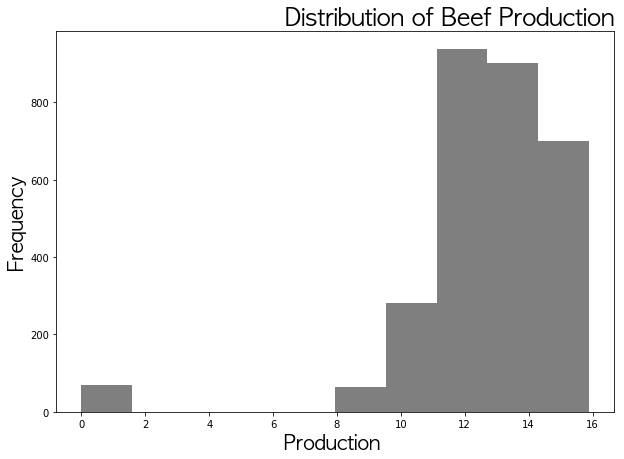

In [252]:
plt.figure(figsize=(10,7))
plt.hist(df_model['production_tons_log'],color='black', alpha=.5)
plt.title('Distribution of Beef Production', family='AppleGothic', loc='right', size=24)
plt.xlabel('Production ', family='AppleGothic', size=20)
plt.ylabel('Frequency', family='AppleGothic', size=20);

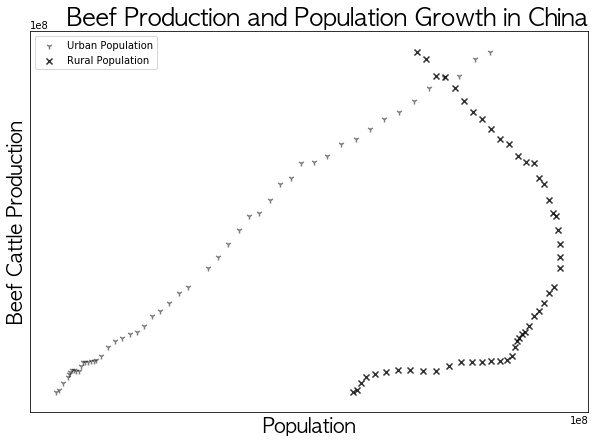

In [256]:
plt.figure(figsize=(10,7))
plt.scatter(df_china['urban_pop_e+01'], df_china['production_tons'], marker='1', c='black', alpha=.5)
plt.scatter(df_china['rural_pop_e+01'], df_china['production_tons'], marker='x',c='black', alpha=.8)
plt.title('Beef Production and Population Growth in China', family='AppleGothic', loc='right', size=24)
plt.xlabel('Population', family='AppleGothic', size=20)
plt.ylabel('Beef Cattle Production', family='AppleGothic', size=20)
plt.legend(['Urban Population', 'Rural Population'])

plt.tick_params(
    axis='x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.tick_params(
    axis='y',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

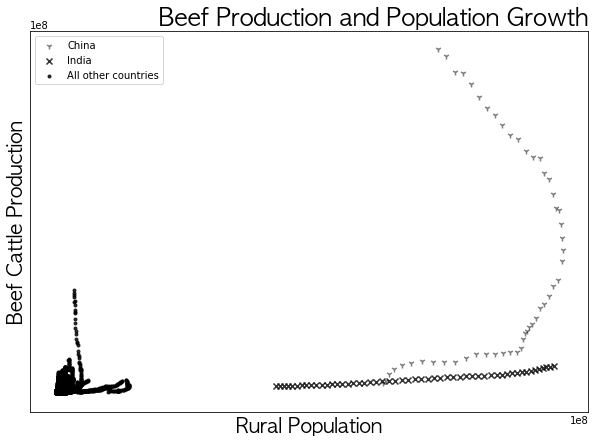

In [257]:
plt.figure(figsize=(10,7))
plt.scatter(df_china['rural_pop_e+01'], df_china['production_tons'], marker='1', c='black', alpha=.5)
plt.scatter(df_india['rural_pop_e+01'], df_india['production_tons'], marker='x',c='black', alpha=.8)
plt.scatter(df_not_china_or_india['rural_pop_e+01'], df_not_china_or_india['production_tons'], marker='.',c='black', alpha=.8)

plt.title('Beef Production and Population Growth', family='AppleGothic', loc='right', size=24)
plt.xlabel('Rural Population', family='AppleGothic', size=20)
plt.ylabel('Beef Cattle Production', family='AppleGothic', size=20)
plt.legend(['China', 'India', 'All other countries'])
plt.tick_params(
    axis='x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.tick_params(
    axis='y',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 
